In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import osmnx as ox
import math
import pandas as pd
import random
from matplotlib import pyplot as plt
import numpy as np
 
from funciones import read_data, calcular_distancia, calcular_matriz_dist, calcular_largo_ruta, graficar_ruta
from instancia import ubis, cap_tpte, info_locales
from instancia import G, color_nodos, color_arcos, ancho_edges
random.seed(42)
np.random.seed(42)

<Figure size 360x360 with 0 Axes>

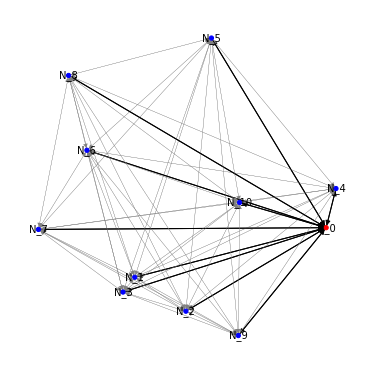

In [85]:
plt.figure(figsize=(5,5))

pos=nx.get_node_attributes(G,'pos')
nx.draw(G, pos=pos, with_labels=True, node_size=18, font_size=10, node_color=color_nodos, width=ancho_edges, edge_color=color_arcos)
plt.show()

In [4]:
matriz_dst = calcular_matriz_dist(G)

In [86]:
def simular_demanda_diaria(data, dist="d",log=False):
    demanda = {}
    demanda[0] = 0
    for i in range(1, len(data)):
        if dist == "p":
            demanda[i] = int(round(np.random.poisson(data[i]),0))
        elif dist == "n":
            demanda[i] = int(round(np.random.normal(data[i], data[i]/10),0))
        elif dist == "u":
            demanda[i] = int(round(np.random.uniform(data[i]/2, data[i]*1.5),0))
        elif dist == "d":

            demanda[i] = int(round(data[i],0))
    
    
    if log:
        print("Demanda del día: ", demanda)
        # print(i, ":", data[i])
    return demanda

dem = simular_demanda_diaria(list(info_locales['r']), dist="d", log=True)


Demanda del día:  {0: 0, 1: 87, 2: 27, 3: 10, 4: 55, 5: 71, 6: 69, 7: 79, 8: 43, 9: 77, 10: 63}


In [71]:
def aplicar_politica_estacionaria(G, info_locales,matriz_dst):
    V = 0
    demanda = simular_demanda_diaria(info_locales['r'][1:],"d")
    for i in range(1,len(info_locales)):
        V += 0
    # Definimos el inventario del día de cada nodo



In [87]:
'''NEAREST NEIGHBOR ALGORITHM FOR VRP'''
def nearest_neighbor(G, dist_matrix, demands, capacity, disponibilidad = None):
    """
    Apply the Nearest Neighbor heuristic to find initial routes for VRP.
    """
    if 'N_0' not in demands.keys():
        demands = {f'N_{k}': v for k, v in demands.items()}
    if disponibilidad is None:
        nodos = list(G.nodes)
    else:
        # recorremos la lista de nodos y nos quedamos con los que tienen disponibilidad
        nodos = [nodo for nodo in list(G.nodes) if disponibilidad[nodo]]
    N = len(nodos)
    visitados = {nodo: False for nodo in nodos}
    rutas = []

    while sum(visitados.values()) < N:
        nodo_actual = 'N_0'
        capacidad_actual = 0
        ruta = [nodo_actual]
        visitados[nodo_actual] = True
        while capacidad_actual + demands[nodo_actual] <= capacity:
            actual = ruta[-1]
            cercano = None
            min_dist = float('inf')
            # print('actual: ', actual)
            for vecino in G.neighbors(actual):

                if vecino not in nodos or visitados[vecino]:
                    # print(f'el nodo {vecino} no está en la lista de nodos')
                    pass
                else:
                    # print(vecino, id_vecino, actual, dist_matrix[actual][id_vecino], demands[vecino])
                    # print(f"vecino: {id_vecino}, distancia: {dist_matrix[actual][id_vecino]} , min_dist: {min_dist}")
                    if demands[vecino] + capacidad_actual <= capacity and dist_matrix[actual][vecino] < min_dist:
                        cercano = vecino
                        # print('cercano: ', cercano)
                        min_dist = dist_matrix[actual][vecino]
            # print(f'Nodo más cercano a {actual}: N_{cercano}')

            if cercano is None:
                print('quibre con: ', ruta)
                break
            else:      
                ruta.append(cercano)
                visitados[cercano] = True
                capacidad_actual += demands[cercano]
        ruta.append('N_0')
            # print('Ruta actual: ', ruta, '\n')
        print('Ruta actual: ', ruta, '\n')
        rutas.append(ruta)
    return rutas

quibre con:  ['N_0', 'N_4', 'N_9', 'N_2', 'N_1', 'N_3', 'N_7', 'N_6', 'N_8', 'N_5']
Ruta actual:  ['N_0', 'N_4', 'N_9', 'N_2', 'N_1', 'N_3', 'N_7', 'N_6', 'N_8', 'N_5', 'N_0'] 

['N_0', 'N_1', 'N_2', 'N_3', 'N_4', 'N_5', 'N_6', 'N_7', 'N_8', 'N_9', 'N_10']


NetworkXError: Node 'N_N_0' has no position.

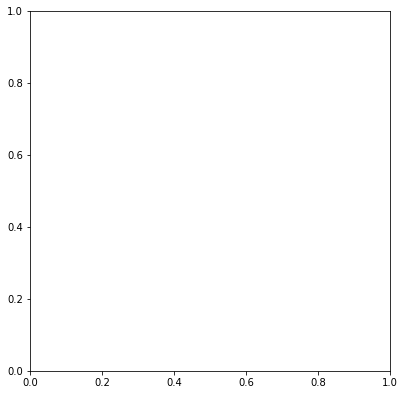

In [88]:
matriz_dst = calcular_matriz_dist(G)
demanda = simular_demanda_diaria(list(info_locales['r']), dist="n")
cap_tpte = cap_tpte
G = G
vetados = ['N_10']
dsp  = {nodo: True for nodo in list(G.nodes) if nodo not in vetados}
for vetado in vetados:
    dsp[vetado] = False
rutas_NN = nearest_neighbor(G, dist_matrix=matriz_dst, demands=demanda, capacity = cap_tpte, disponibilidad = dsp)
print(G.nodes())
graficar_ruta(rutas_NN[0], G)

In [9]:
calcular_largo_ruta(rutas_NN[0], matriz_dst)


1483.1524937291247

In [10]:
   # num_points = len(dist_matrix)
    # visited = np.zeros(num_points, dtype=bool)
    # routes = []

    # while np.sum(visited) < num_points:
    #     current_node = 0  # Start at node 0
    #     current_capacity = 0
    #     route = [current_node]
    #     visited[current_node] = True

    #     while current_capacity + demands[current_node] <= capacity:
    #         current = route[-1]
    #         nearest = None
    #         min_dist = float('inf')

    #         for neighbor in np.where(~visitados)[0]:
    #             if demands[neighbor] + current_capacity <= capacity and dist_matrix[current, neighbor] < min_dist:
    #                 nearest = neighbor
    #                 min_dist = dist_matrix[current, neighbor]

    #         if nearest is None:
    #             break

    #         route.append(nearest)
    #         visitados[nearest] = True
    #         current_capacity += demands[nearest]

    #     routes.append(route)

    # return routes

In [67]:
'''TWO OPT ALGORITHM FOR VRP'''

def two_opt(ruta_inicial, matriz_dst, iters):
     
    ruta_2opt = ruta_inicial.copy()

    for k in range(iters):
        i, j = np.random.randint(1, len(ruta_2opt) - 1, size=2)
        if j < i:
            i, j = j, i

        nueva_ruta = ruta_2opt.copy()
        nueva_ruta[i:j] = ruta_2opt[j - 1: i - 1: -1]
        
        if calcular_largo_ruta(nueva_ruta, matriz_dst) < calcular_largo_ruta(ruta_2opt, matriz_dst):
            print("Mejora encontrada")
            print("Ruta anterior: ", ruta_2opt)
            print("Nueva ruta: ", nueva_ruta)
            ruta_2opt = nueva_ruta
    
    return ruta_2opt

rutas_2opt = [two_opt(ruta, matriz_dst, 1000) for ruta in rutas_NN]
[0, 4, 10, 2, 9, 1, 3, 7, 6, 8, 5, 0]

graficar_ruta(rutas_2opt[0], G)

KeyError: 'N_N_0'

Ruta: ['N_0', 'N_4', 'N_9', 'N_2', 'N_1', 'N_3', 'N_7', 'N_6', 'N_8', 'N_5', 'N_0'] en color: red
Agregando arco: N_0 -> N_4 en color: red
Agregando arco: N_4 -> N_9 en color: red
Agregando arco: N_9 -> N_2 en color: red
Agregando arco: N_2 -> N_1 en color: red
Agregando arco: N_1 -> N_3 en color: red
Agregando arco: N_3 -> N_7 en color: red
Agregando arco: N_7 -> N_6 en color: red
Agregando arco: N_6 -> N_8 en color: red
Agregando arco: N_8 -> N_5 en color: red
Agregando arco: N_5 -> N_0 en color: red
Ruta: [0, 4, 10, 9, 2, 1, 3, 7, 6, 8, 5, 0] en color: black
Agregando arco: 0 -> 4 en color: black
Agregando arco: 4 -> 10 en color: black
Agregando arco: 10 -> 9 en color: black
Agregando arco: 9 -> 2 en color: black
Agregando arco: 2 -> 1 en color: black
Agregando arco: 1 -> 3 en color: black
Agregando arco: 3 -> 7 en color: black
Agregando arco: 7 -> 6 en color: black
Agregando arco: 6 -> 8 en color: black
Agregando arco: 8 -> 5 en color: black
Agregando arco: 5 -> 0 en color: black
d

NetworkXError: Node 'N_N_0' has no position.

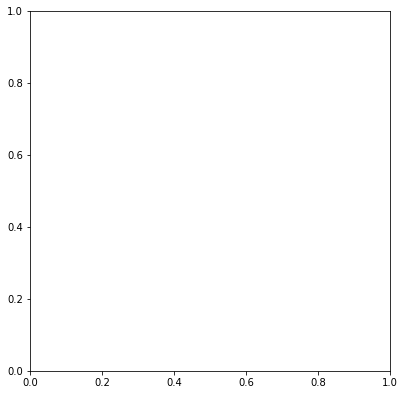

In [66]:
def graficar_rutas(rutas, G):
    colores = ['blue', 'green', 'orange', 'purple','black','red']
    grafo = nx.DiGraph()
    nodos = list(G.nodes())
    color_nodos = []
    color_edges = []
    for nodo in nodos:
        id_nodo = int(nodo[2:])
        grafo.add_node(nodo, pos=G.nodes()[nodo]['pos'])
        if id_nodo != 0:
            color_nodos.append('black')
        else:
            color_nodos.append('green')
    for ruta in rutas:
        color = colores[-1]
        colores.remove(color)
        print(f'Ruta: {ruta} en color: {color}')

        for i in range(len(ruta)-1):
            n1, n2 = ruta[i], ruta[i+1]
            grafo.add_edge(f'N_{n1}', f'N_{n2}', color=color)
            print(f'Agregando arco: {n1} -> {n2} en color: {color}')
            color_edges.append(color)

    plt.figure(figsize=(5,5))
    colors = nx.get_edge_attributes(grafo,'color').values()
    print(colors)
    pos=nx.get_node_attributes(G,'pos')
    # edges = grafo.edges()
    nx.draw(grafo, pos=pos, with_labels=True, node_size=18, font_size=15,  node_color = color_nodos, edge_color = colors)
    plt.show()
    

ruta_0 = [0, 4, 2, 10, 9, 3, 1, 8, 7, 6, 5, 0]
rutas = [ rutas_NN[0], rutas_2opt[0]]

graficar_rutas(rutas, G)

In [13]:
    # best_routes = routes.copy()

    # for k in range(iters):
    #     selected_route_idx = np.random.randint(0, len(routes))
    #     selected_route = routes[selected_route_idx]

    #     i, j = np.random.randint(1, len(selected_route) - 1, size=2)
    #     if j < i:
    #         i, j = j, i

    #     new_route = selected_route.copy()
    #     new_route[i:j] = selected_route[j - 1: i - 1: -1]  # Reverse the path between i and j

    #     new_routes = routes.copy()
    #     new_routes[selected_route_idx] = new_route

    #     if calcular_largo_ruta(new_routes[selected_route_idx], dist_matrix) < calcular_largo_ruta(
    #             best_routes[selected_route_idx], dist_matrix
    #     ):
    #         best_routes = new_routes

    # return best_routes

In [14]:
# copiaremos demanda cambiando las keys de x a N_x
demanda_2 = dict()
for i in range(len(demanda)):
    demanda_2[f'N_{i}'] = demanda[i]

In [15]:
from alns import ALNS
from alns.accept import RecordToRecordTravel, SimulatedAnnealing
from alns.select import RouletteWheel
from alns.stop import MaxRuntime

In [16]:
class IRPState:
    '''
    Estado de solución del IRP
    '''
    def __init__(self,routes, unnasigned=None):
        self.routes = routes # será solo una ruta ya que es solo un vehículo
        self.unnasigned = unnasigned if unnasigned is not None else []
    
    def copy(self):
        return IRPState(self.routes.copy(), self.unnasigned.copy())

    def objective(self):
        ruta = self.routes[0][:]
        ruta = [int(x.split('_')[-1]) for x in ruta]
        return calcular_largo_ruta(ruta, matriz_dst)
    
    @property
    def cost(self):
        return self.objective()
    
    def find_route(self, node):
        for route in self.routes:
            if node in route:
                return route

In [17]:
degree_of_destruction = 0.05
nodes_to_destroy = int(np.ceil(degree_of_destruction * len(G.nodes)))
nodes_to_destroy

1

In [18]:
degree_of_destruction = 0.05
nodes_to_destroy = int(np.ceil(degree_of_destruction * len(G.nodes)))


def random_removal(state, random_state):
    destroyed = state.copy()

    for node in random_state.choice(
        range(1, len(G.nodes)), nodes_to_destroy, replace=False
    ):
        node = f"N_{node}"
        destroyed.unnasigned.append(node)
        route = destroyed.find_route(node)
        if route is not None:
            route.remove(node)
       

    non_empty_routes = [ruta for ruta in destroyed.routes if len(ruta) > 0]
    
    destroyed.routes = non_empty_routes
    return destroyed


In [19]:
# repair operators

def greedy_repair(state, random_state):
    repaired = state.copy()

    random_state.shuffle(repaired.unnasigned)
    
    while len(repaired.unnasigned) > 0:

        node = repaired.unnasigned.pop()
        route, idx = best_insert(node, repaired)
        if route is not None:
            route.insert(idx, node)
        else:
            repaired.routes.append([node])
    
    return repaired

def best_insert(node, state):

    best_cost, best_route, best_idx = float('inf'), None, None

    for route in state.routes:
        for i in range(len(route) + 1):
            if can_insert(node, route):
                cost = insertion_cost(node, route, i)

                if cost < best_cost:
                    best_cost = cost
                    best_route = route
                    best_idx = i
    
    return best_route, best_idx

def can_insert(node, route):
    total = sum([demanda_2[nodo] for nodo in route])
    return total + demanda_2[node] <= cap_tpte

def insertion_cost(node, route, idx):
    pred = 'N_0' if idx == 0 else route[idx - 1]
    succ = 'N_0' if idx == len(route) else route[idx]

    dist = matriz_dst[pred][node] + matriz_dst[node][succ] - matriz_dst[pred][succ]
    return dist

In [20]:
def neighbors(node):
    # ordenaremos los nodo por distancia al nodo actual
    return sorted(G.neighbors(node), key=lambda x: matriz_dst[node][x])

def nearest_neighbor_adapted():
    '''
    Adaptación del algoritmo Nearest Neighbor descrito anteriormente para que se utilice con la 
    clase IRPState
    '''
    routes = []
    available = list(G.nodes)
    available.remove('N_0')
    route = ['N_0'] #siempre empezamos en el nodo 0
    route_demands = 0

    while available:
        current = route[-1]

        my_neighbors = neighbors(current)
        while my_neighbors[0] in route:
            my_neighbors = my_neighbors[1:]
        nearest = my_neighbors[0]


        if route_demands + demanda_2[nearest] <= cap_tpte:
            route.append(nearest)
            route_demands += demanda_2[nearest]
            # print('nodesd:', nodes, 'nearest:', nearest)
            available.remove(nearest)
        else:
            break
    routes.append(route)

    return IRPState(routes)


In [21]:
def simple_forecaster(x):
    # recive el diccionario de demanda y devuelve un diccionario con una demanda levemente modificada
    for key in x.keys():
        noise = np.random.normal(0, 5)
        x[key] = int(round(x[key] + noise,0))


In [22]:
T = 10 # periodos
V = 10 # vertices
def proactive_routing_only():
    
    print('iniciando...')
    init = nearest_neighbor_adapted()
    for t in range(T):
        # print(init.routes)
        #for i in range(1, len(init.routes[t-1])):   # QUIZAS EST'E AFECTANDO NO MODIFICAR LAS DEMANDAS
            # d = simple_forecaster(x)
        #    pass

        alns = ALNS(np.random.RandomState(42))
        alns.add_destroy_operator(random_removal)
        alns.add_repair_operator(greedy_repair)

        select = RouletteWheel([10, 5, 2, 0], 0.7, 1, 1)
        accept = SimulatedAnnealing(start_temperature=20000,
                            end_temperature=0.1,
                            step= 0.9993,
                            method="exponential")
        stop = MaxRuntime(60)

        result = alns.iterate(init, select, accept, stop)
        init = result.best_state
    
    return result

        


In [23]:
# TESTEO DE PROACTIVE ROUTING ONLY

x = proactive_routing_only()
x

iniciando...


KeyboardInterrupt: 